In [95]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import DBSCAN

%matplotlib inline

Image shape: (480, 640, 3)



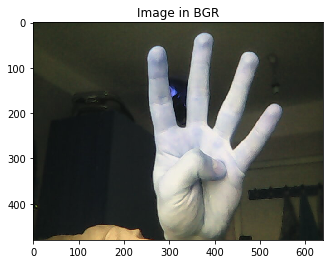

In [207]:
image = './memage2.jpg'
image = cv2.imread(image)
print(f"Image shape: {image.shape}\n")
plt.title("Image in BGR")
plt.imshow(image)

CPU times: user 207 ms, sys: 5.73 ms, total: 213 ms
Wall time: 231 ms


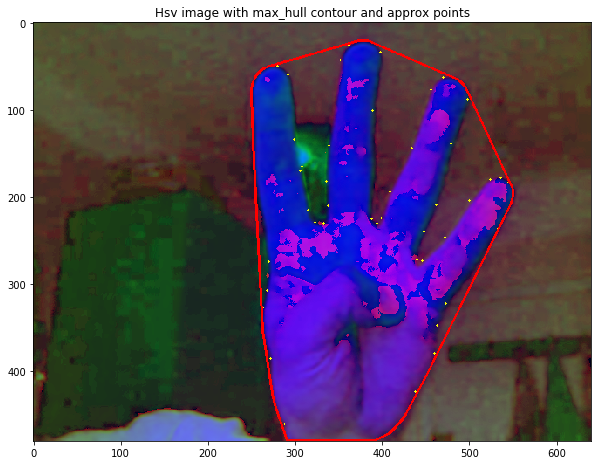

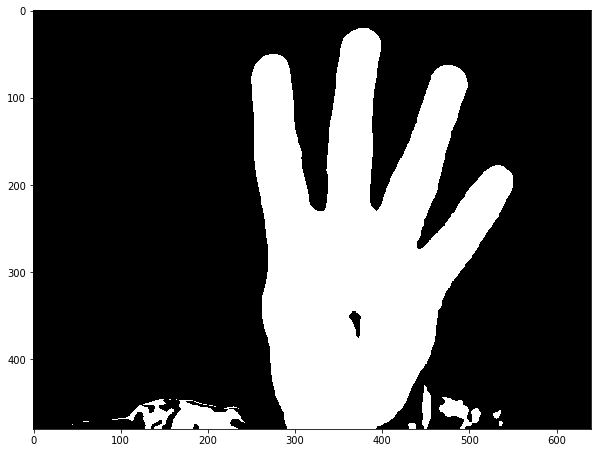

In [208]:
%%time

image2 = image.copy()

image = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower = np.array([0, 0, 80])
upper = np.array([255, 120, 255])
mask = cv2.GaussianBlur(image, (5, 5), 100)
mask = cv2.inRange(mask, lower, upper)

contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

max_contour = max(contours,key=lambda x: cv2.contourArea(x))
cnt = contours[0] # delete excess dim for list
max_hull = cv2.convexHull(max_contour)
epsilon = 0.001*cv2.arcLength(max_contour,True)
approx= cv2.approxPolyDP(max_contour,epsilon,True)


leftmost = max_hull[max_hull[:,:,0].argmin()][0]
rightmost = max_hull[max_hull[:,:,0].argmax()][0]
delta = np.linalg.norm(leftmost-rightmost) // 8

center = np.mean(max_hull, axis=0,dtype=np.uint32)
cx, cy = tuple(center[0])
cy += 100
final = cv2.drawContours(image, approx, -1,(255,255,0), 2)

final = cv2.drawContours(image, [max_hull], -1,(255,0,0), 2)
plt.figure(figsize=(10,10))
plt.title("Hsv image with max_hull contour and approx points")
plt.imshow(final) #cmap='gray', interpolation='nearest')
plt.figure(figsize=(10,10))
plt.imshow(mask, cmap='gray')
plt.imsave('for_masim.png',mask)

CPU times: user 98.9 ms, sys: 0 ns, total: 98.9 ms
Wall time: 99.5 ms


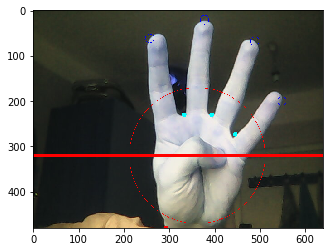

In [210]:
%%time

def check_for_maxhull(point, max_hull,measure):
    for index in range(len(max_hull)-1):
        if per_distance(max_hull[index],max_hull[index+1],point) < measure:
            return False
    return True

def per_distance(lp1, lp2, p):
    return np.linalg.norm(np.cross(lp2-lp1, lp1-p))/np.linalg.norm(lp2-lp1)

image3 = image2.copy()
real_points = []

distance = lambda i, j: np.linalg.norm(i-j)
vect_dist = np.vectorize(distance)

data = np.array(np.squeeze(approx,axis=1))[:,1]
indexes, _ = peakdet(data,.2)
if indexes.size > 0:
        real_points = []
        corner_points = np.take(np.array(np.squeeze(approx,axis=1)), indexes[:,0],axis=0)
        for point in corner_points:
            if check_for_maxhull(point,max_hull,20) is True and point[1]<cy:
                cv2.circle(image3, tuple(point), 5, (0, 255, 255),-1)
                real_points.append(tuple(point))

max_hull_top = np.array([i[0] for i in max_hull if i[0][1] < cy])
clustering = DBSCAN(eps=14, min_samples=1).fit(max_hull_top)
labels = clustering.labels_
means = []
for i in np.unique(labels):
    if i >= 0 and np.count_nonzero(labels==i) >= 2:
        array = []
        for num, j in enumerate(labels):
            if j == i:
                array.append(max_hull_top[num])
        if array != []:
            ax,ay = tuple(np.squeeze(np.mean(np.array(array),axis=0)))
            cv2.circle(image3,(int(ax),int(ay)) ,10, (0,0,255), 1)
            means.append((int(ax),int(ay)))
cv2.circle(image3, tuple((int(cx),int(cy))),150,(255,0,0),1)
Bottom = tuple(c[c[:, :, 1].argmax()][0])
cv2.line(image3,(0,cy),(640,cy),(255,0,0),5)
cv2.circle(image3,Bottom,5,(255,0,0),-1)
plt.imshow(image3)

In [211]:
def get_neighb(elem, narray):
    elem = elem.tolist()
    array = narray.copy()
    array.append(elem)
    array = sorted(array, key=lambda x:x[0])
    index = array.index(elem)
    
    if index > 0 and index != len(array)-1:
        return np.array([array[index-1], array[index+1]])
    else:
        return np.array(np.zeros((2,)))

def get_angle(p1, p2, p3):
    line1 = p2 - p1
    line2 = p3 - p1
    cosine = np.dot(line1, line2) / (np.linalg.norm(line1) * np.linalg.norm(line2))
    angle = np.arccos(cosine)
    print(angle * 180 / np.pi)
    return angle * 180 / np.pi

In [212]:
def find_nearest(means, roots, image):
    """
    Built angles between fingers and count fingers

    Arguments:
    means -- array of tuples (point on the finger's edge)
    roots -- array of tuples (point between fingers)
    image -- numpy array of shape (n, m, 3)

    Return:
    None
    """
    means = sorted(means, key=lambda x: x[0])
    roots = sorted(roots, key=lambda x: x[0])

    means = np.array(means)
    roots = np.array(roots)
    n = len(means)-len(roots)
    #if n > 1:
    #    for _ in range(n-1):
    #        roots = np.vstack([roots, roots[-1]])

    count_finger = 0
    for i in range(len(means)-1):
        if i == len(roots):
            break
        angle = get_angle(roots[count_finger], means[i], means[i+1])

        if angle > 10 and angle < 80 and distance(roots[count_finger], means[i+1]) > 70 \
            and distance(roots[count_finger], means[i]) > 70 \
            and means[i+1][1] < roots[count_finger][1] \
            and means[i][1] < roots[count_finger][1]:

            cv2.line(image, tuple(roots[count_finger]), tuple(means[i+1]), (0,255,0),4)
            cv2.line(image, tuple(roots[count_finger]), tuple(means[i]), (0,255,0),4)
            count_finger += 1

    if count_finger >= 1 and count_finger <= 5:
        cv2.putText(image, str(count_finger+1),(0,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3, cv2.LINE_AA)
    if count_finger == 0:
        cv2.putText(image, str(1),(0,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3, cv2.LINE_AA)

36.49200097760672
34.76594278028487
42.82696129918406


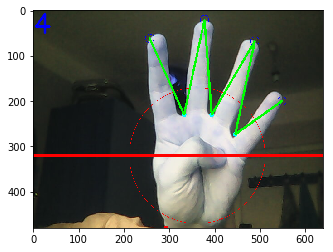

In [213]:
find_nearest(means,real_points,image3)
plt.imshow(image3)

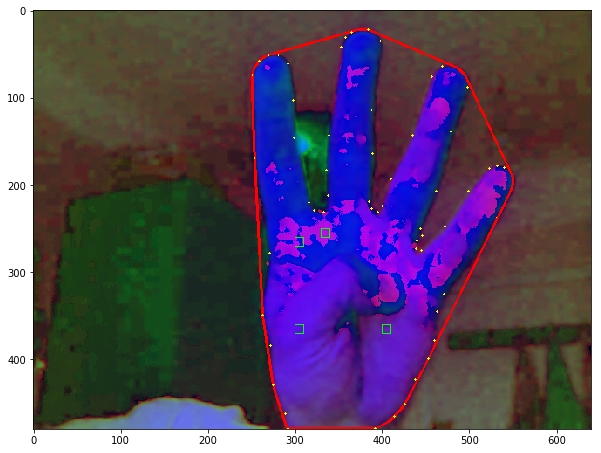

In [206]:
def peakdet(v, delta, x=None):
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
    v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)
